In [8]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# read a file
gdrive_path = '/content/drive/MyDrive/mydata/'

**Import Data and Data Visualization**

In [10]:
#read the reviews
import pandas as pd

data = pd.read_csv("IMDB_Dataset.csv", error_bad_lines=False)
data.sample(n=10)

<ipython-input-10-297507c9285a>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv("IMDB_Dataset.csv", error_bad_lines=False)


,review,sentiment
3210,"First thing I noticed in this movie of course,...",negative
6924,I watched Hurlyburly as a second choice after ...,negative
32905,I have a two year old son who suffers from the...,positive
41831,"A fantastic movie, and very overlooked. Gary h...",positive
41556,Being a self confessed slasher addict means th...,positive
13725,I grew up watching Full House as a child. I st...,positive
26804,STAR RATING: ***** The Works **** Just Misses ...,negative
44801,"Like most everyone who views this movie, I did...",negative
49599,I saw Teen Devian in 1993 telecasted in Doorda...,positive
4968,"More like psychological analysis of movies, bu...",positive


In [11]:
data.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  This show comes up with interesting locations ...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

In [12]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

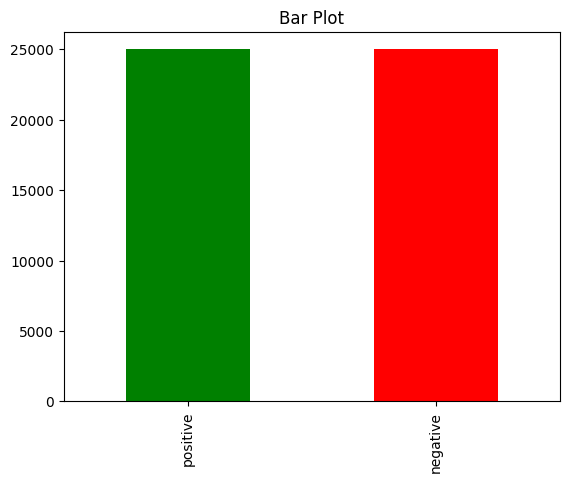

In [13]:
import matplotlib.pyplot as plt

count_Class=pd.value_counts(data["sentiment"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show()

In [14]:
data['label'] = data['sentiment'].replace(['positive', 'negative'],['1', '0'])

In [15]:
neg_data  = data[data['label'] == 0].copy()
pos_data = data[data['label'] == 1].copy()

**Import Modules**

In [19]:
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
from collections import Counter
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

In [20]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "positive"
NEGATIVE = "negative"
NEUTRAL = "neutral"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "Sentiment_lstm_w2v.sav"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "lstm_w2v_tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


Text(0.5, 1.0, 'Dataset labels distribuition')

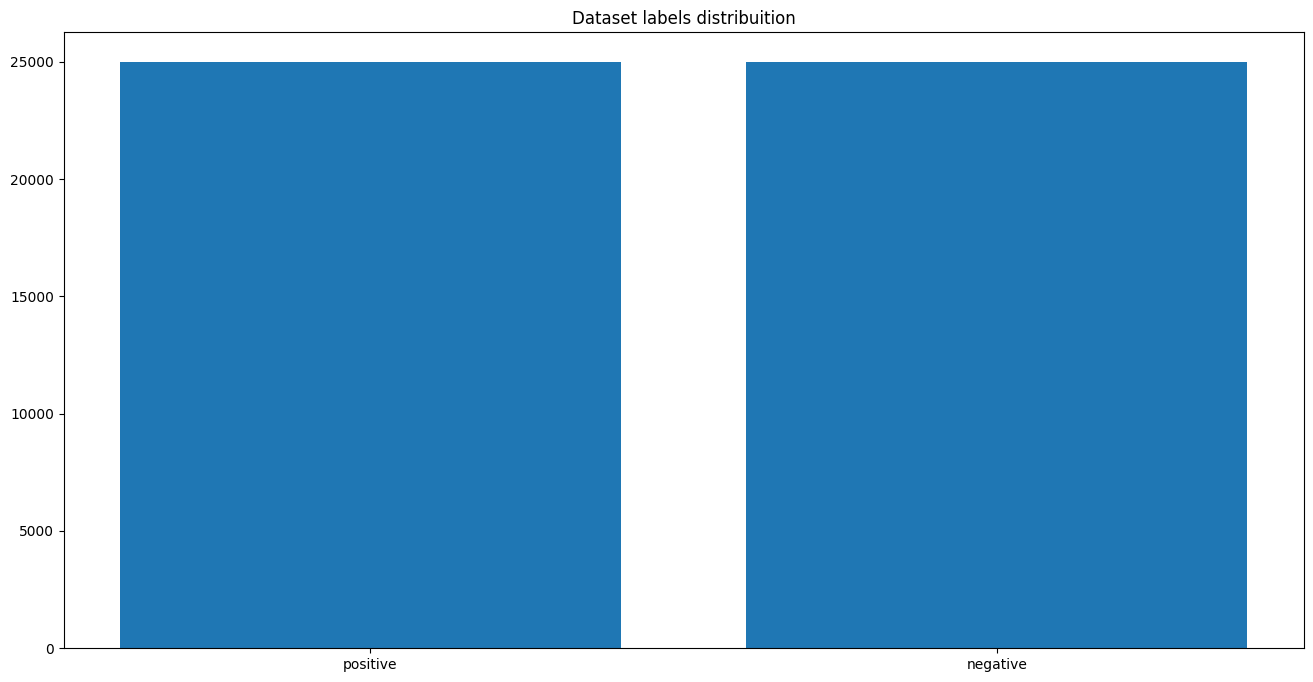

In [21]:
target_cnt = Counter(data.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

**Data Preprocessing**

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [24]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [25]:
%%time
data.review = data.review.apply(lambda x: preprocess(x))

CPU times: user 31.1 s, sys: 75 ms, total: 31.2 s
Wall time: 33.3 s


In [26]:
data.sample(n=10)

,review,sentiment,label
6309,film brought tears say beautiful husband home ...,positive,1
33567,1990 tv show movie 1979 looks three episodes t...,negative,0
6104,saw movie show showing bad b movies trying get...,negative,0
31267,hell first reaction film actually first reacti...,negative,0
39118,film excellent premise really crying turned ho...,positive,1
29059,lights new york first taking feature film comi...,positive,1
31078,thomas archer ron eldard child killed wife vic...,negative,0
34263,film succeed film festival karlovy vary czech ...,positive,1
42206,older videos dvds dr played adore doctors diff...,positive,1
49489,sure headed ending turned liberal conspiracy h...,negative,0


In [27]:
# split data into train and test set
X = data['review'].values
y = data['sentiment'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [28]:
%%time
documents = [_text.split() for _text in data.review]

CPU times: user 443 ms, sys: 164 ms, total: 606 ms
Wall time: 609 ms


In [29]:
print(len(documents))

50000


**CBOW Word2Vec Model Training**

In [30]:
# Train CBOW Word2Vec model
w2vmodel = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8, sg=0)


In [31]:
words = w2vmodel.wv.index_to_key
vocab_size_wv = len(words)
print("Vocab size:", vocab_size_wv)

Vocab size: 28058


In [32]:
w2vmodel.wv.most_similar("movie")

[('film', 0.6769565939903259),
 ('movies', 0.6114296913146973),
 ('flick', 0.5977498292922974),
 ('thats', 0.5046753287315369),
 ('suck', 0.4882381856441498),
 ('guess', 0.48036348819732666),
 ('figured', 0.47484201192855835),
 ('sucked', 0.46493253111839294),
 ('think', 0.46279072761535645),
 ('sure', 0.4623345136642456)]

**Tokenization**

In [33]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.review)



CPU times: user 4.2 s, sys: 115 ms, total: 4.32 s
Wall time: 4.23 s


In [34]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 100947


**Data Preparation for Model Training**

In [35]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

CPU times: user 4.42 s, sys: 26.8 ms, total: 4.45 s
Wall time: 4.5 s


In [36]:
labels = data.sentiment.unique().tolist()
labels.append("neutral")
labels

['positive', 'negative', 'neutral']

In [37]:
encoder = LabelEncoder()
encoder.fit(data.sentiment.tolist())

y_train = encoder.transform(Y_train.tolist())
y_test = encoder.transform(Y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [38]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [39]:
y_train[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

**Embedding layer**

In [40]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2vmodel.wv:
        embedding_matrix[i] = w2vmodel.wv[word]
print(embedding_matrix.shape)

(100947, 300)


In [41]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

**Build Model**

In [42]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          30284100  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirection  (None, 200)               320800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 30605101 (116.75 MB)
Trainable params: 321001 (1.22 MB)
Non-trainable params: 30284100 (115.52 MB)
_________________________________________________________________


**Compile model**

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Callbacks**

In [44]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)] #change 'val_acc' to 'val_accuracy'

**Train Model**

In [45]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

model.save(KERAS_MODEL)
w2vmodel.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)



Epoch 1/32
36/36 [==============================] - 109s 3s/step - loss: 0.5171 - accuracy: 0.7429 - val_loss: 0.3822 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 2/32
36/36 [==============================] - 89s 2s/step - loss: 0.3899 - accuracy: 0.8329 - val_loss: 0.3774 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 3/32
36/36 [==============================] - 91s 2s/step - loss: 0.3404 - accuracy: 0.8596 - val_loss: 0.3924 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 4/32
36/36 [==============================] - 93s 3s/step - loss: 0.3165 - accuracy: 0.8678 - val_loss: 0.4029 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 5/32
36/36 [==============================] - 89s 2s/step - loss: 0.3040 - accuracy: 0.8738 - val_loss: 0.3325 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 6/32
36/36 [==============================] - 91s 2s/step - loss: 0.2904 - accuracy: 0.8799 - val_loss: 0.2840 - val_accuracy: 0.8895 - lr: 0.0010
Epoch 7/32
36/36 [==============================] - 92s 3s/step - loss: 0.2809 - 

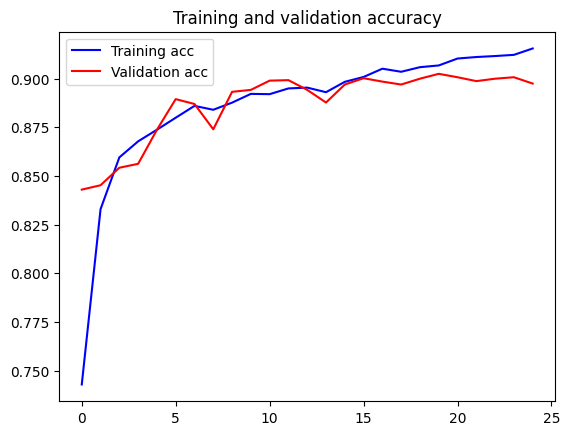

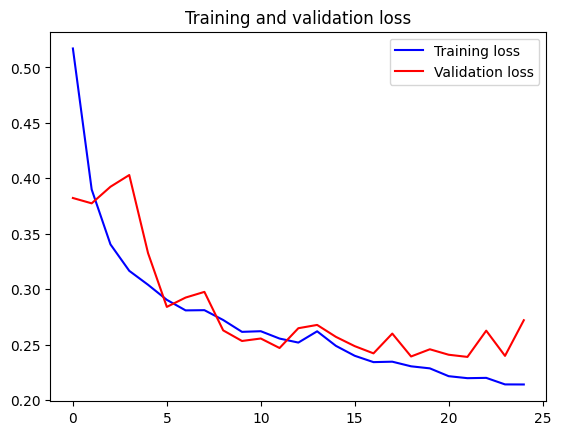

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Evaluate using Test Data**

In [47]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 2s 208ms/step - loss: 0.2752 - accuracy: 0.8960

ACCURACY: 0.8960000276565552
LOSS: 0.2752484381198883
CPU times: user 1.85 s, sys: 317 ms, total: 2.16 s
Wall time: 2.24 s


**Predict**

In [49]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [50]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [51]:
predict("I think this is a very great movie.")

1/1 [==============================] - 1s 573ms/step


{'label': 'positive',
 'score': 0.9042635560035706,
 'elapsed_time': 0.623363733291626}

**Confusion Matrix**

In [52]:
%%time
y_pred_1d = []
y_test_1d = list(Y_test)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 2s 347ms/step
CPU times: user 1.53 s, sys: 425 ms, total: 1.96 s
Wall time: 2.01 s


In [53]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

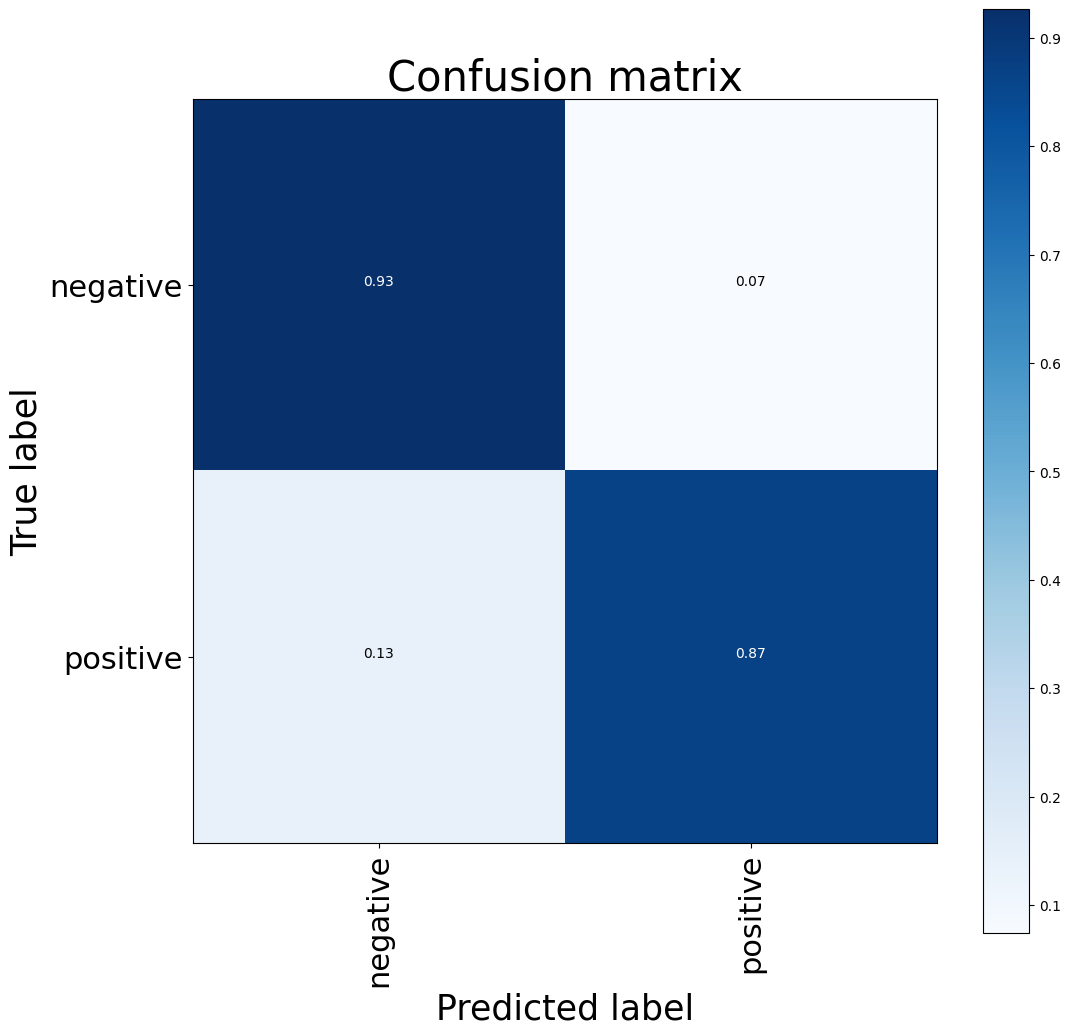

CPU times: user 501 ms, sys: 151 ms, total: 652 ms
Wall time: 623 ms


In [54]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_train), title="Confusion matrix")
plt.show()

**Classification Report**

In [55]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.87      0.93      0.90      4961
    positive       0.92      0.87      0.89      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



**Accuracy Score**

In [56]:
accuracy_score(y_test_1d, y_pred_1d)

0.896

**Save model**

In [57]:
model.save(f"{gdrive_path}{KERAS_MODEL}")
w2vmodel.save(f"{gdrive_path}{WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{gdrive_path}{TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{gdrive_path}{ENCODER_MODEL}", "wb"), protocol=0)

In [59]:
# download the trained model
import shutil
shutil.make_archive("/content/drive/MyDrive/mydata", 'zip', "/content/drive/MyDrive/mydata")

from google.colab import files
files.download("/content/drive/MyDrive/mydata.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>